In [1]:
## initialization 1214

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

# Reinforcement Learning in Serial Dependence

在这一部分中，我们从零开始，组块化地去思考强化学习算法和贝叶斯算法在 Serial Dependence 问题中的应用。<br> <br> 由于这部分实验的最主要目的其实集中于探究 RL 的作用，所以我们先从强化学习的框架开始模拟生成实际的数据，并以分析得到的数据为基础，采用分析 SD 的方式来探索是否 RL 足以解释目前的发现。

## 1 Basic Model Free Reinforcement Learning

The most primitive type of reinforcement learning specifies on learning of **action**, which then takes form of the most basic **Q Learning** and modifies the value of the very action chosen. This is model-free because it does not make any assumptions about the world nor the state space. 

即，在第一个最基本的模型中，我们的被试只对按键左右（action）进行价值积累；前面所涉及的所有，目标朝向和按键 mapping 所构成的状态空间并不被考虑。

### Mathematical Formulation

**Q**: the value of each action, 1 x 2 vector for LeftKey and RightKey

**Update Rule**: $Q_{t+1}(a_t) = Q_t(a_t) + \alpha \cdot (r_t - Q_t(a_t))$

Since this is a perceptual task, the basic decision rule should be made by choosing the action that indicates the correct orientation of the stimulus.

Due to the threshold-level sensory noise, the observer takes into account the probability of the action being correct, and then makes the decision.

**Utility**: $U_t(a_t) = Q_t(a_t) \cdot p_t(a_t)$

For each trial, the observer caculates the Utility of each action, and then select the action with the highest utility.

**Action Selection**: $a_t = \arg\max_{a_t} U_t(a_t)$

And, we assume that the **Feedback Signal** is already the reward as it is:

**Reward**: $r_t = f_t = \begin{cases} 1 & \text{if correct} \\ 0 & \text{if incorrect} \end{cases}$




### Generative Process of Orientation Perception

The common standard deviation is:  0.7413011092528007
The average hit rate is:  0.750232
The average correct rejection rate is:  0.748818


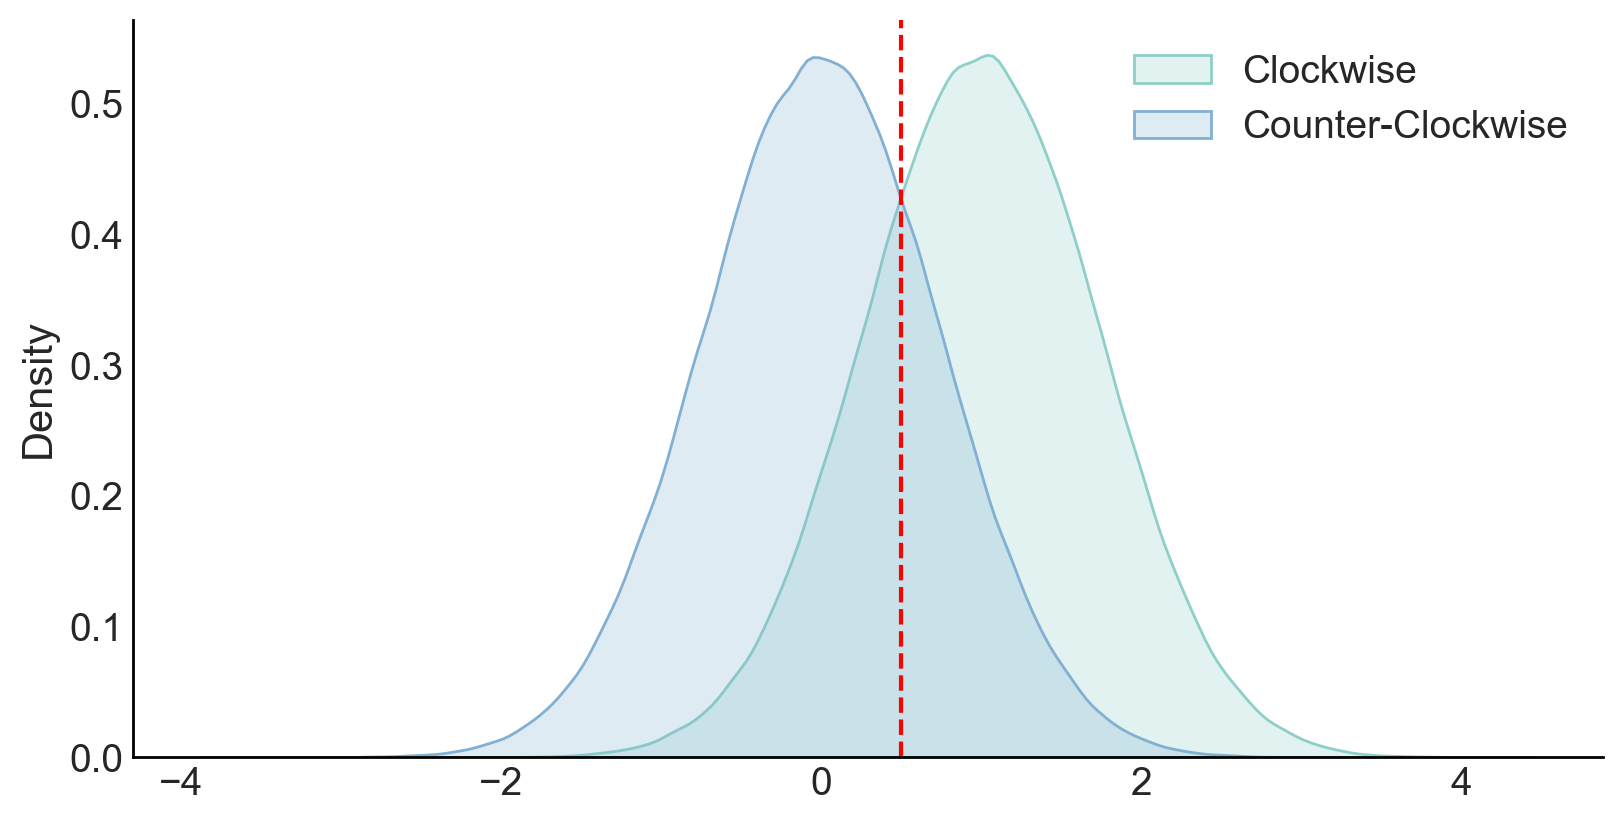

In [2]:
# @title Orientation Judgement under SDT
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve

# We set the hit rate to 0.75 and assume Clockwise is the signal (1:CW, 0:CCW)
Goal_Hit_Prob = 0.75
signal_mean = 1 
noise_mean = 0
criterion = 0.5 # we assume the criterion is 0.5, since the two orientations are equally likely

# Calculate the most probable common standard deviation
def find_std(std):
    return stats.norm.cdf(criterion, signal_mean, std) - 0.25

# rep_times = 1000 # the number of times we repeat the optimization to find the best solution
# opt_std = []
# for irep in range(rep_times):
#     std_initial_guess = np.random.uniform(0.1, 1.0)
#     std_solution = fsolve(find_std, std_initial_guess)
#     opt_std.append(std_solution[0])
    
# common_std = np.mean(opt_std)
common_std = 0.7413011092528007
print('The common standard deviation is: ', common_std)

# Test if this parameter set can generate average hit rate of 0.75
# Generate a set of 10000 random samples from a normal distribution with mean = 1.0, std = common_std
sample_size = 1000000
samples_1 = np.random.normal(signal_mean, common_std, int(sample_size/2))
samples_2 = np.random.normal(noise_mean, common_std, int(sample_size/2))
samples = np.concatenate((samples_1, samples_2), axis=0)
                    
# Calculate the average hit rate and correct rejection rate
hit_rate = np.sum(samples_1 > criterion) / len(samples_1)
print('The average hit rate is: ', hit_rate)
cr_rate = np.sum(samples_2 < criterion) / len(samples_2)
print('The average correct rejection rate is: ', cr_rate)

# Visualize the distributions of the two orientations
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(samples_1, shade=True, color=gr, label='Clockwise')
sns.kdeplot(samples_2, shade=True, color=bl, label='Counter-Clockwise')
plt.axvline(x=criterion, color='r', linestyle='--')
plt.legend()
plt.show()

In [4]:
# The perception process is reduced to a SDT model
def Data_Gen(trialnum, 
             signal_mean = 1, noise_mean = 0, criterion = 0.5, std = 0.7413011092528007):
    '''
    Generate data with noise for a given number of trials.
    '''
    samples_1 = np.random.normal(signal_mean, std, int(trialnum/2))
    labels_1 = np.ones(int(trialnum/2))
    samples_2 = np.random.normal(noise_mean, std, int(trialnum/2))
    labels_2 = np.zeros(int(trialnum/2))
    samples = np.concatenate((samples_1, samples_2), axis=0)
    labels = np.concatenate((labels_1, labels_2), axis=0)
    # shuffle the data
    idx = np.arange(trialnum)
    np.random.shuffle(idx)
    samples = samples[idx]
    labels = labels[idx]
    likelihood_signal = stats.norm.cdf(samples, criterion, std)
    likelihood_noise = 1 - stats.norm.cdf(samples, criterion, std)
    likelihood = np.vstack((likelihood_noise,likelihood_signal))
    return samples, labels, likelihood


samples, labels, likelihood = Data_Gen(10)

data_table = pd.DataFrame({'samples': samples, 'labels': labels, 'likelihood_noise': likelihood[0], 'likelihood_signal': likelihood[1]})
data_table.head()

,samples,labels,likelihood_noise,likelihood_signal
0,-0.039715,1.0,0.766713,0.233287
1,-0.758083,0.0,0.955164,0.044836
2,-0.483402,1.0,0.907678,0.092322
3,-0.926382,0.0,0.972833,0.027167
4,1.356905,1.0,0.123851,0.876149


In [44]:
# Simulate the Reinforcement Learning process per trial

def RL_1_per_trial(posterior, mapping, v_L, v_R, label, learning_rate, reward = 1, punishment = -1):
    '''
    Simulate the Reinforcement Learning process per trial.
    param posterior: the posterior probability of the signal : [\  /], this model is just likelihood
    param mapping: the mapping of the response keys: [\  /] or [/  \], 1 for [\  /] and 2 for [/  \]
    param v_L, v_R: the value of the left and right action
    param label: the label of the stimulus: 1 for CW / and 0 for CCW \ 
    param learning_rate: the learning rate of the RL model
    param reward/punishment: the reward and punishment value for the correct response
    
    Return: 
    action: the action chosen by the model, -1 for left and 1 for right
    resp_ori: the orientation of the response, 1 for CW / and 0 for CCW \ 
    feedback: the feedback given by the environment, 1 for correct and 0 for incorrect
    v_L, v_R: the updated value of the left and right action
    '''
    key_mapping = {-1: [0, 1], 1: [1, 0]}
    
    if mapping == 1:
        U_L = posterior[0] * v_L
        U_R = posterior[1] * v_R
    else:
        U_L = posterior[1] * v_L
        U_R = posterior[0] * v_R
    
    # choose the action with the larger utility and receive the feedback
    action = np.sign(U_R - U_L)
    resp_ori = key_mapping[action][mapping-1]
    feedback = int(resp_ori == label)
    r = reward if feedback else punishment
    
    # update the value of the chosen action
    if action == -1:
        v_L += learning_rate * (r - v_L)
    else:
        v_R += learning_rate * (r - v_R)
    
    return action, resp_ori, feedback, v_L, v_R

# Simulate the Reinforcement Learning process for a given number of trials
# Demonstration Data
trial_num = 50
learning_rate = 0.1
v_L_0 = 0.5
v_R_0 = 0.5

data_samples, data_labels, posterior = Data_Gen(trial_num)
mapping = np.random.choice([1, 2], trial_num)
Sim_Data = pd.DataFrame(columns=['trial', 'stimulus', 'label', 'posterior CCW', 'posterior CW', 'action', 'resp_ori', 'feedback', 'v_L', 'v_R', 'mapping'])

for iT in range(trial_num):
    posterior_i = posterior[:, iT]
    mapping_i = mapping[iT]
    label_i = data_labels[iT]
    data_samples_i = data_samples[iT]
    if iT == 0:
        v_L_i = v_L_0
        v_R_i = v_R_0
    else:
        v_L_i = v_L
        v_R_i = v_R
    action_i, resp_ori_i, feedback_i, v_L, v_R = RL_1_per_trial(posterior_i, mapping_i, v_L_i, v_R_i, label_i, learning_rate)
    temp_data = pd.DataFrame({'trial': iT+1, 'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0], 'posterior CW': posterior_i[1], 
                              'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i, 'v_L': v_L_i, 'v_R': v_R_i, 'mapping': mapping_i}, index=[iT])
    Sim_Data = pd.concat([Sim_Data, temp_data], axis=0)
    
Sim_Data.head()

,trial,stimulus,label,posterior CCW,posterior CW,action,resp_ori,feedback,v_L,v_R,mapping
0,1,1.490926,1.0,0.090654,0.909346,1.0,1,1,0.50,0.5000,1
1,2,1.421220,1.0,0.106988,0.893012,-1.0,1,1,0.50,0.5500,2
2,3,-0.172833,0.0,0.817965,0.182035,1.0,0,1,0.55,0.5500,2
3,4,1.384774,1.0,0.116329,0.883671,1.0,1,1,0.55,0.5950,1
4,5,1.420103,1.0,0.107266,0.892734,-1.0,1,1,0.55,0.6355,2


In [52]:
data_labels

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.])

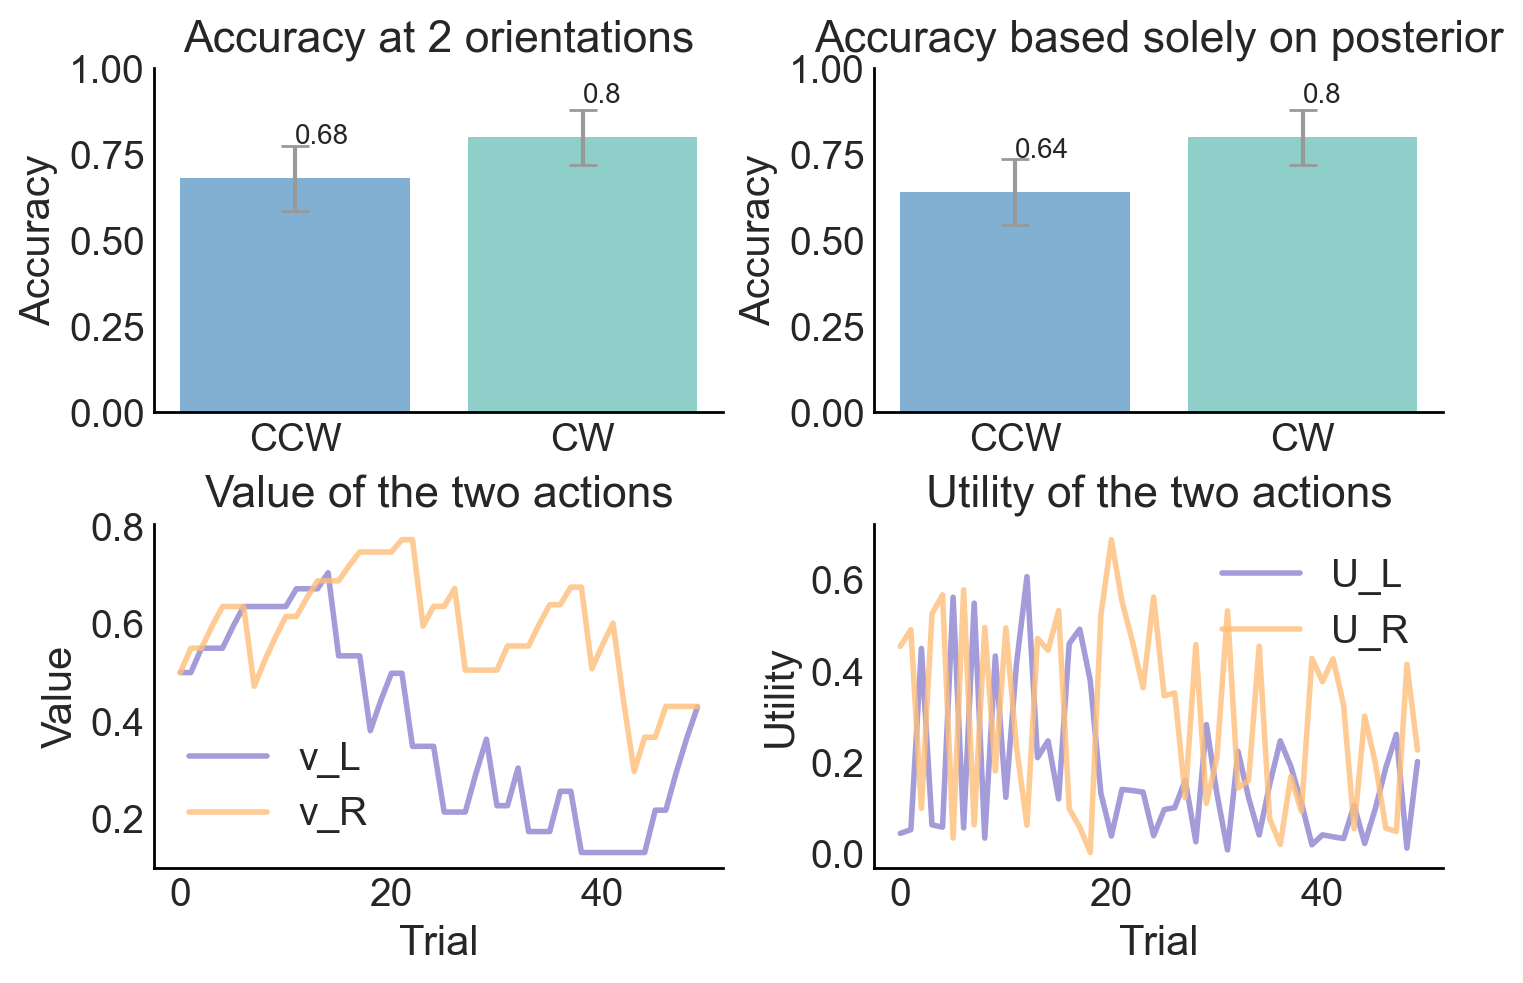

In [45]:
# visualize the performance
plt.subplot(2,2,1)
perform_at_0 = Sim_Data[Sim_Data['label'] == 0]['feedback']
perform_at_1 = Sim_Data[Sim_Data['label'] == 1]['feedback']
plt.bar(0, np.mean(perform_at_0), color=bl, label='CCW')
plt.errorbar(0, np.mean(perform_at_0), yerr=np.std(perform_at_0)/np.sqrt(len(perform_at_0)), color = ak, capsize=5)
plt.text(0, np.mean(perform_at_0)+0.1, str(np.round(np.mean(perform_at_0), 2)))
plt.bar(1, np.mean(perform_at_1), color=gr, label='CW')
plt.errorbar(1, np.mean(perform_at_1), yerr=np.std(perform_at_1)/np.sqrt(len(perform_at_1)), color = ak, capsize=5)
plt.text(1, np.mean(perform_at_1)+0.1, str(np.round(np.mean(perform_at_1), 2)))
plt.xticks([0, 1], ['CCW', 'CW'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy at 2 orientations')

# if decision is made solely based on posterior probability:
plt.subplot(2,2,2)
ori_higher_likelihood = Sim_Data['posterior CW'] > Sim_Data['posterior CCW']
ori_higher_likelihood.replace({True: 1, False: 0})
percept_at_0 = (ori_higher_likelihood[Sim_Data['label'] == 0] == 0)
percept_at_1 = (ori_higher_likelihood[Sim_Data['label'] == 1] == 1)
plt.bar(0, np.mean(percept_at_0), color=bl, label='CCW')
plt.errorbar(0, np.mean(percept_at_0), yerr=np.std(percept_at_0)/np.sqrt(len(percept_at_0)), color = ak, capsize=5)
plt.text(0, np.mean(percept_at_0)+0.1, str(np.round(np.mean(percept_at_0), 2)))
plt.bar(1, np.mean(percept_at_1), color=gr, label='CW')
plt.errorbar(1, np.mean(percept_at_1), yerr=np.std(percept_at_1)/np.sqrt(len(percept_at_1)), color = ak, capsize=5)
plt.text(1, np.mean(percept_at_1)+0.1, str(np.round(np.mean(percept_at_1), 2)))
plt.xticks([0, 1], ['CCW', 'CW'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy based solely on posterior')

# visualize the v_L and v_R
plt.subplot(2,2,3)
plt.plot(Sim_Data['v_L'], color=vio, label='v_L', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['v_R'], color=ye, label='v_R', alpha=0.8, linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Value of the two actions')
plt.legend()

# the utility of the two actions
plt.subplot(2,2,4)
plt.plot(Sim_Data['posterior CCW'] * Sim_Data['v_L'], color=vio, label='U_L', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['posterior CW'] * Sim_Data['v_R'], color=ye, label='U_R', alpha=0.8, linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Utility')
plt.title('Utility of the two actions')
plt.legend()
plt.show()



In [53]:
# run 30 subjects, each with 20 blocks, each block has 50 trials

##### Params Setting ########
maxsubj = 30
maxblock = 20
num_trials = 50
learning_rate = 0.1
v_L_0 = 0.5
v_R_0 = 0.5

##### Data Simulation #######
all_subj_data = pd.DataFrame(columns=['subj', 'block', 'trial', 
                                      'stimulus', 'label', 'posterior CCW', 'posterior CW', 
                                      'action', 'resp_ori', 'feedback', 'v_L', 'v_R', 'mapping'])

for iS in range(1, maxsubj + 1):
    for iB in range(1, maxblock + 1):
        data_samples, data_labels, posterior = Data_Gen(trial_num)
        mapping = np.random.choice([1, 2], trial_num)
        for iT in range(num_trials):
                posterior_i = posterior[:, iT]
                mapping_i = mapping[iT]
                label_i = data_labels[iT]
                data_samples_i = data_samples[iT]
                if iT == 0:
                    v_L_i = v_L_0
                    v_R_i = v_R_0
                else:
                    v_L_i = v_L
                    v_R_i = v_R
                action_i, resp_ori_i, feedback_i, v_L, v_R = RL_1_per_trial(posterior_i, mapping_i, v_L_i, v_R_i, label_i, learning_rate)
                temp_data = pd.DataFrame({'subj': iS, 'block': iB, 'trial': iT +1,
                                          'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0], 'posterior CW': posterior_i[1], 
                                          'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i, 'v_L': v_L_i, 'v_R': v_R_i, 'mapping': mapping_i}, index=[iT])
                all_subj_data = pd.concat([all_subj_data, temp_data], axis=0)

all_subj_data.head()

,subj,block,trial,stimulus,label,posterior CCW,posterior CW,action,resp_ori,feedback,v_L,v_R,mapping
0,1,1,1,2.547589,1.0,0.002871,0.997129,-1.0,1,1,0.5000,0.50,2
1,1,1,2,-0.395148,0.0,0.886387,0.113613,-1.0,0,1,0.5500,0.50,1
2,1,1,3,1.565280,1.0,0.075353,0.924647,-1.0,1,1,0.5950,0.50,2
3,1,1,4,0.904284,1.0,0.292749,0.707251,1.0,1,1,0.6355,0.50,1
4,1,1,5,-1.646211,0.0,0.998105,0.001895,-1.0,0,1,0.6355,0.55,1


In [56]:
# Reorganize the data for Serial Dependence analysis
trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
all_data = {}

maxsubj = 30; maxblock = 20;
for iS in range(1, maxsubj + 1):
    subject_data = []
    raw_subj = all_subj_data[all_subj_data['subj'] == iS]
    for iB in range(1, maxblock + 1):
        block_data = raw_subj[raw_subj['block'] == iB]
        temp_data = trial_template.copy()
        temp_data['StimSeq'] = block_data['label'].values.copy()
        temp_data['StimSeq'].replace({0: -45, 1: 45}, inplace=True)
        temp_data['RespOri'] = block_data['resp_ori'].values.copy()
        temp_data['RespOri'].replace({0: -45, 1: 45}, inplace=True)
        temp_data['RespLorR'] = block_data['action'].values.copy()
        temp_data['Accuracy'] = block_data['feedback'].values.copy()
        temp_data['ProbeOriLeft'] = block_data['mapping'].values.copy()
        temp_data['ProbeOriLeft'].replace({1: -45, 2: 45}, inplace=True)
        temp_data['ProbeOriRight'] = block_data['mapping'].values.copy()
        temp_data['ProbeOriRight'].replace({1: 45, 2: -45}, inplace=True)
        temp_data['Qualified'] = True
        subject_data.append(temp_data)
    all_data[iS] = subject_data
    
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

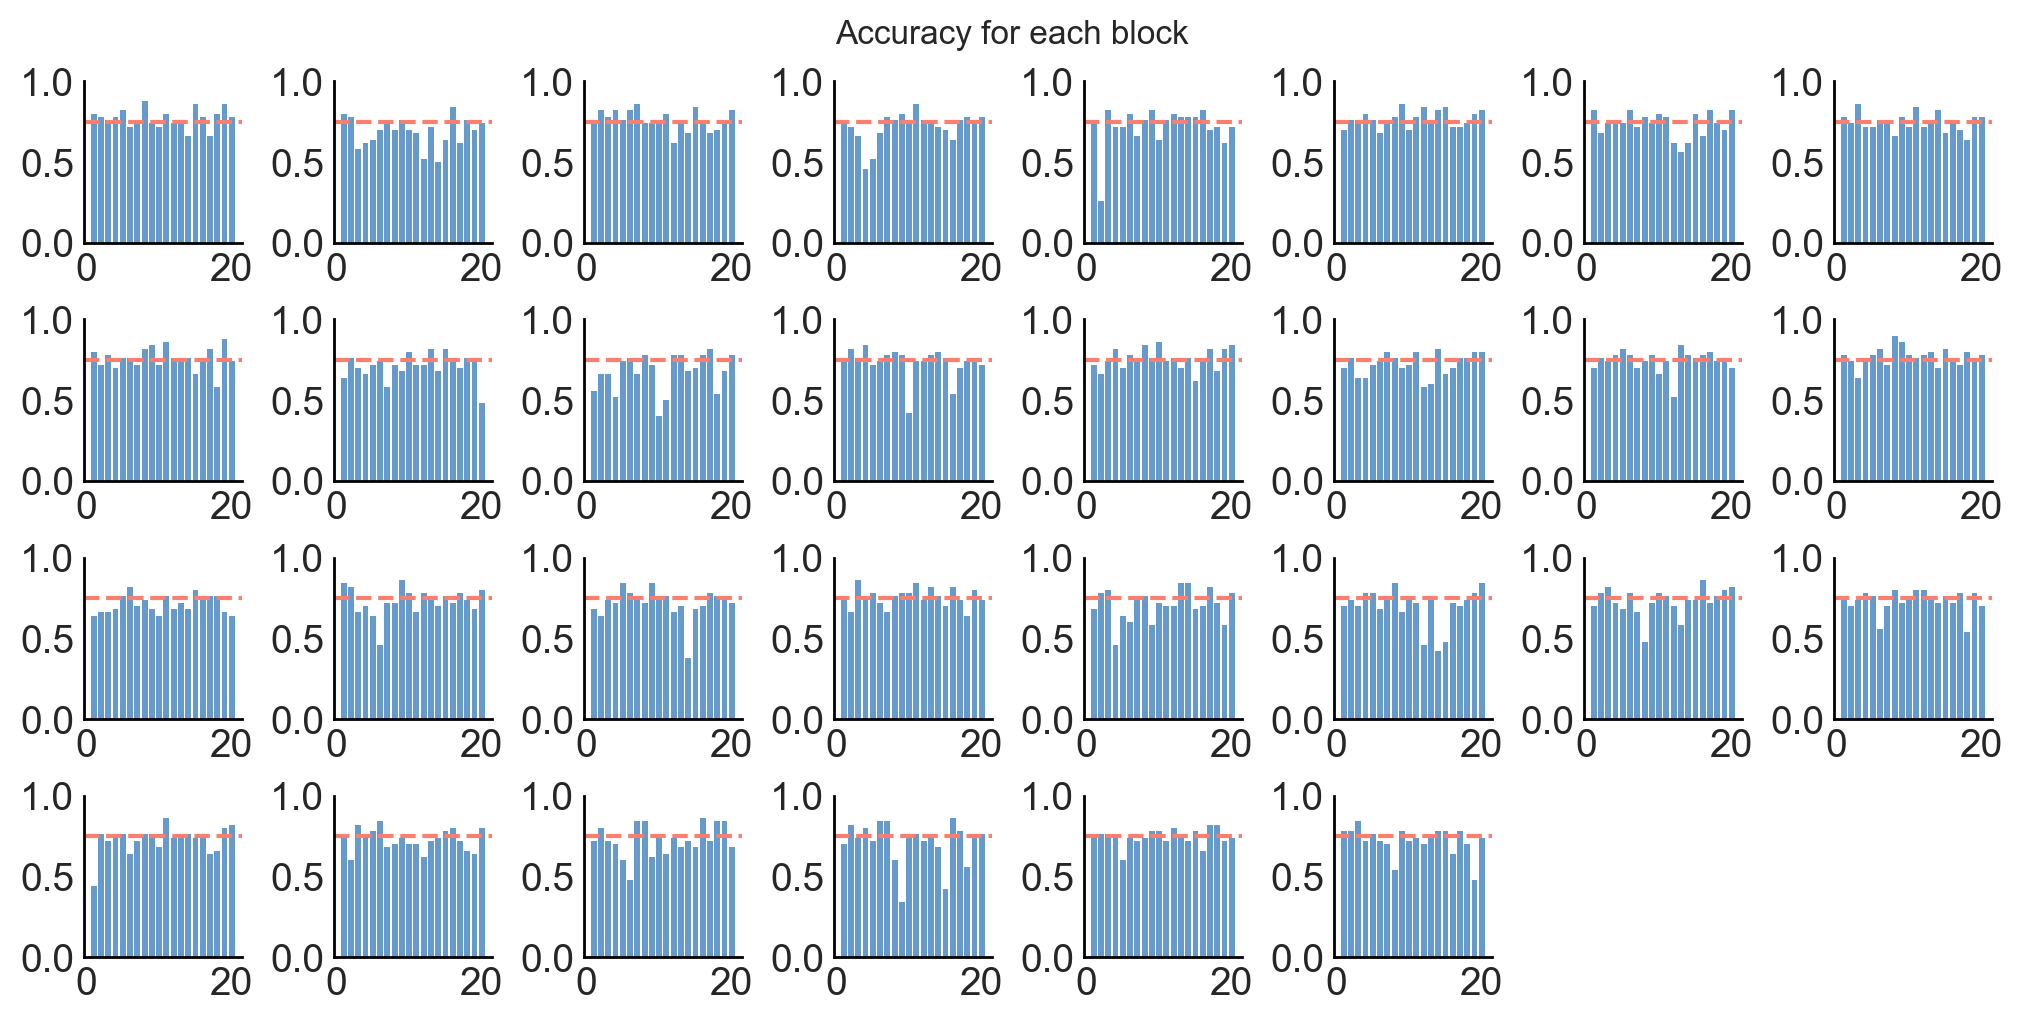

In [63]:
maxsubj = 30; maxblock = 20; maxtrial = 50

fig = plt.figure(figsize=(10, 5))

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    temp_accuracy = {f"{i}_block": {} for i in range(1, maxblock + 1)}
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        temp_accuracy[key] = np.mean(block_data['Accuracy'])
    plt.subplot(4, 8, iS)
    plt.bar([int(i.split('_')[0]) for i in temp_accuracy.keys()], temp_accuracy.values(), color=grb)
    plt.ylim([0, 1])
    plt.axhline(y=0.75, color=re, linestyle='--')
    
fig.suptitle('Accuracy for each block')
plt.show()

In [73]:
def process_data_percept_cb(data, back):
    """Return hits and false alarms for a specific n-back"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

def calculate_sd_nback_percept_cb(all_data):
    maxsubj = 30; maxblock = 20; maxtrial = 50; num_backs = 10
    SD_nback_Percept_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_percept_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_n"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[key]["Hit"])
            fas = np.concatenate(temp_data[key]["FA"])
            hits_n = np.concatenate(temp_data[key]["Hit_n"])
            fas_n = np.concatenate(temp_data[key]["FA_n"])
            cs = criterion(np.mean(hits_n), np.mean(fas_n)) - criterion(np.mean(hits), np.mean(fas))
            SD_nback_Percept_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Percept_cb)


def process_data_motor_cb(data, back):
    """Return hits and false alarms for motor responses"""
    hit_L, fa_L = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Qualified'] == True)])
    hit_R, fa_R = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Qualified'] == True)])
    return (hit_L, fa_L, hit_R, fa_R)

def calculate_sd_nback_motor_cb(all_data):
    maxsubj = 30; maxblock = 20; num_backs = 10
    SD_nback_Motor_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_motor_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_R"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_L = np.concatenate(temp_data[key]["Hit_L"])
            fas_L = np.concatenate(temp_data[key]["FA_L"])
            hits_R = np.concatenate(temp_data[key]["Hit_R"])
            fas_R = np.concatenate(temp_data[key]["FA_R"])
            cs = criterion(np.mean(hits_L), np.mean(fas_L)) - criterion(np.mean(hits_R), np.mean(fas_R))
            SD_nback_Motor_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Motor_cb)



In [86]:
# we run a simulation for multiple learning rates and see how it affects the SD effect

learning_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]
# prepare a matrix to store the SD effect for each learning rate, each n-back
rep_times = 50

SD_Percept_alphas = np.zeros((len(learning_rates), 10))
SD_Motor_alphas = np.zeros((len(learning_rates), 10))

##### Params Setting ########
maxsubj = 30
maxblock = 20
num_trials = 50
v_L_0 = 0.5
v_R_0 = 0.5

for irep in range(rep_times):
    if irep % 10 == 0:
        print(f"Simulation {irep} out of {rep_times}")
    
    SD_Percept_alphas_i = np.zeros((len(learning_rates), 10))
    SD_Motor_alphas_i = np.zeros((len(learning_rates), 10))
    for i, alpha in enumerate(learning_rates):
        all_subj_data = pd.DataFrame(columns=['subj', 'block', 'trial', 
                                            'stimulus', 'label', 'posterior CCW', 'posterior CW', 
                                            'action', 'resp_ori', 'feedback', 'v_L', 'v_R', 'mapping'])

        for iS in range(1, maxsubj + 1):
            for iB in range(1, maxblock + 1):
                data_samples, data_labels, posterior = Data_Gen(trial_num)
                mapping = np.random.choice([1, 2], trial_num)
                for iT in range(num_trials):
                        posterior_i = posterior[:, iT]
                        mapping_i = mapping[iT]
                        label_i = data_labels[iT]
                        data_samples_i = data_samples[iT]
                        if iT == 0:
                            v_L_i = v_L_0
                            v_R_i = v_R_0
                        else:
                            v_L_i = v_L
                            v_R_i = v_R
                        action_i, resp_ori_i, feedback_i, v_L, v_R = RL_1_per_trial(posterior_i, mapping_i, v_L_i, v_R_i, label_i, alpha)
                        temp_data = pd.DataFrame({'subj': iS, 'block': iB, 'trial': iT +1,
                                                'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0], 'posterior CW': posterior_i[1], 
                                                'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i, 'v_L': v_L_i, 'v_R': v_R_i, 'mapping': mapping_i}, index=[iT])
                        all_subj_data = pd.concat([all_subj_data, temp_data], axis=0)

        trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
        all_data = {}
        for iS in range(1, maxsubj + 1):
            subject_data = []
            raw_subj = all_subj_data[all_subj_data['subj'] == iS]
            for iB in range(1, maxblock + 1):
                block_data = raw_subj[raw_subj['block'] == iB]
                temp_data = trial_template.copy()
                temp_data['StimSeq'] = block_data['label'].values.copy()
                temp_data['StimSeq'].replace({0: -45, 1: 45}, inplace=True)
                temp_data['RespOri'] = block_data['resp_ori'].values.copy()
                temp_data['RespOri'].replace({0: -45, 1: 45}, inplace=True)
                temp_data['RespLorR'] = block_data['action'].values.copy()
                temp_data['Accuracy'] = block_data['feedback'].values.copy()
                temp_data['ProbeOriLeft'] = block_data['mapping'].values.copy()
                temp_data['ProbeOriLeft'].replace({1: -45, 2: 45}, inplace=True)
                temp_data['ProbeOriRight'] = block_data['mapping'].values.copy()
                temp_data['ProbeOriRight'].replace({1: 45, 2: -45}, inplace=True)
                temp_data['Qualified'] = True
                subject_data.append(temp_data)
            all_data[iS] = subject_data
        
        SD_nbacks_Percept = calculate_sd_nback_percept_cb(all_data)
        SD_nbacks_Motor = calculate_sd_nback_motor_cb(all_data)
        SD_Percept_alphas_i[i, :] = SD_nbacks_Percept.mean(axis=0).values
        SD_Motor_alphas_i[i, :] = SD_nbacks_Motor.mean(axis=0).values
        
        SD_Motor_alphas[i, :] += SD_Motor_alphas_i[i, :]
        SD_Percept_alphas[i, :] += SD_Percept_alphas_i[i, :]
    
SD_Motor_alphas /= rep_times
SD_Percept_alphas /= rep_times


Running simulation for alpha = 0
Running simulation for alpha = 0.01
Running simulation for alpha = 0.05
Running simulation for alpha = 0.1
Running simulation for alpha = 0.2
Running simulation for alpha = 0.3
Running simulation for alpha = 0.5
Running simulation for alpha = 0.7
Running simulation for alpha = 1


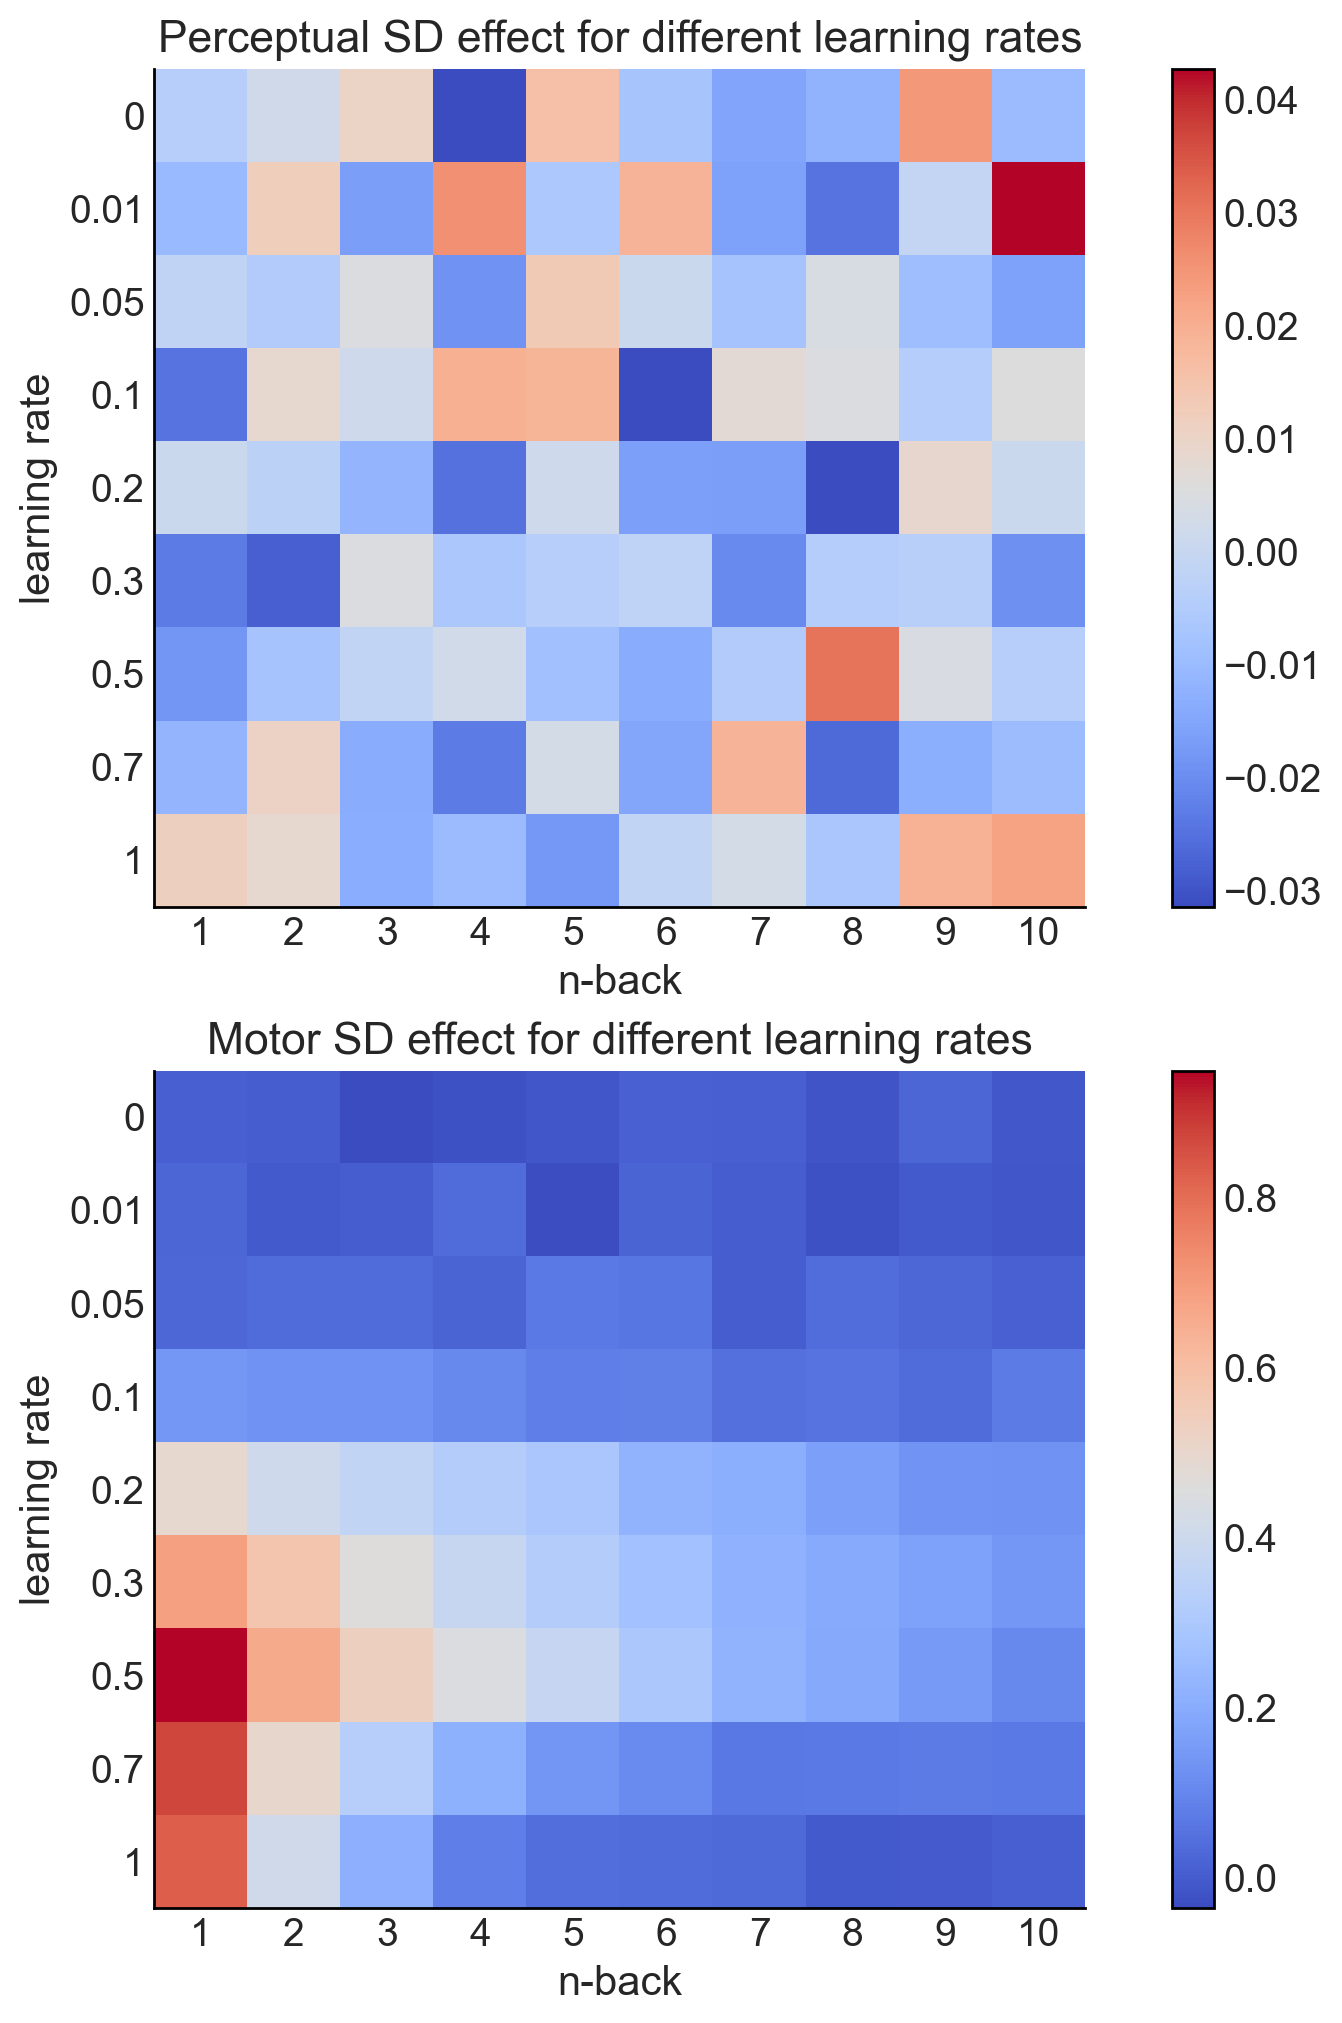

In [87]:
# visualize the SD matrix

fig = plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.imshow(SD_Percept_alphas, cmap='coolwarm')
plt.colorbar()
plt.xlabel('n-back')
plt.ylabel('learning rate')
plt.xticks(range(10), range(1, 11))
plt.yticks(range(len(learning_rates)), learning_rates)
plt.title('Perceptual SD effect for different learning rates')

plt.subplot(2,1,2)
plt.imshow(SD_Motor_alphas, cmap='coolwarm')
plt.colorbar()
plt.xlabel('n-back')
plt.ylabel('learning rate')
plt.xticks(range(10), range(1, 11))
plt.yticks(range(len(learning_rates)), learning_rates)
plt.title('Motor SD effect for different learning rates')
plt.show()



# X Save Progress

In [88]:
import dill
import datetime
path = './Data/'
model_name = 'model_3'
date = datetime.datetime.today().strftime('%Y%m%d')
filename = f'{path}{model_name}_{date}.db'
print(filename)
dill.dump_session(filename)

./Data/model_3_20231224.db


In [2]:
import dill
filename = './Data/model_3_20231224.db'
dill.load_session(filename)